In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=15_000,
    k=k,
    min_length=8,
    max_length=16,
    balanced=0.5,
)

File data/dyck-1_15000-samples_16-len_p05.jsonl already exists.


In [8]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-1_15000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 15000/15000 [00:00<00:00, 114453.16it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=True)

# Manual Transformer + BERTViz


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=4,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=8,
)

In [16]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [17]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-5)

In [19]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=7,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.2551 | Train Accuracy: 80.88%
Train Loss: 0.0294 | Train Accuracy: 90.41%
Train Loss: 0.0097 | Train Accuracy: 93.60%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.1364 | Validation Accuracy: 100.00%
Validation Loss: 0.2752 | Validation Accuracy: 100.00%
Train Loss: 60.6064 | Train Acc: 94.88%
Val Loss: 0.3097 | Val Acc: 100.00%
Epoch 2/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0033 | Train Accuracy: 100.00%
Train Loss: 0.0020 | Train Accuracy: 100.00%
Train Loss: 0.0013 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0235 | Validation Accuracy: 100.00%
Validation Loss: 0.0471 | Validation Accuracy: 100.00%
Train Loss: 0.9528 | Train Acc: 100.00%
Val Loss: 0.0528 | Val Acc: 100.00%
Epoch 3/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0085 | Validation Accuracy: 100.00%
Validation Loss: 0.0170 | Validation Accuracy: 100.00%
Train Loss: 0.2610 | Train Acc: 100.00%
Val Loss: 0.0191 | Val Acc: 100.00%
Epoch 4/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0041 | Validation Accuracy: 100.00%
Validation Loss: 0.0081 | Validation Accuracy: 100.00%
Train Loss: 0.1156 | Train Acc: 100.00%
Val Loss: 0.0091 | Val Acc: 100.00%
Epoch 5/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0024 | Validation Accuracy: 100.00%
Validation Loss: 0.0048 | Validation Accuracy: 100.00%
Train Loss: 0.0618 | Train Acc: 100.00%
Val Loss: 0.0054 | Val Acc: 100.00%
Epoch 6/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0016 | Validation Accuracy: 100.00%
Validation Loss: 0.0031 | Validation Accuracy: 100.00%
Train Loss: 0.0392 | Train Acc: 100.00%
Val Loss: 0.0035 | Val Acc: 100.00%
Epoch 7/7


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Validation Loss: 0.0022 | Validation Accuracy: 100.00%
Train Loss: 0.0269 | Train Acc: 100.00%
Val Loss: 0.0025 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Validation Loss: 0.0022 | Validation Accuracy: 100.00%
Test Loss: 0.0022 | Test Acc: 100.00%


train_acc,▁▅▆▇▇▇██████████████████████████████████
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▇█▇▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,6e-05
val_acc,100.0
val_loss,1e-05


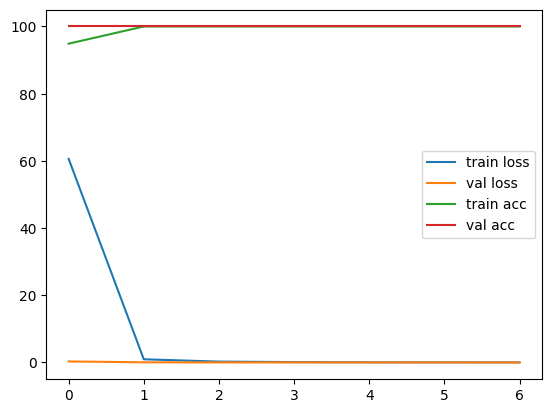

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [ ]:
model_causal = TransformerClassifier(model_config).to(device)

In [ ]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-6)

In [ ]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

In [ ]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

# Attention plots:


In [101]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [102]:
from dataset.dataset import DyckLanguageTokenizer
from dyck_k_generator.checker import is_dyck_word

In [103]:
batch = [
    (
        ")))))))(((((((",
        "((((((()))))))",
        ")()()()()()()(",
        "()()()()()()()"
    ),
    torch.tensor(
        [
            is_dyck_word(")))))))(((((((", 1),
            is_dyck_word("((((((()))))))", 1),
            is_dyck_word(")()()()()()()(", 1),
            is_dyck_word("()()()()()()()", 1),
        ],
        dtype=torch.float32,
        device=device,
    ),
    torch.tensor(
        [
            DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("((((((()))))))").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize(")()()()()()()(").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("()()()()()()()").tolist()[0],
        ],
        device=device,
    ),
]
batch

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


[(')))))))(((((((', '((((((()))))))', ')()()()()()()(', '()()()()()()()'),
 tensor([0., 1., 0., 1.], device='mps:0'),
 tensor([[0., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 2.],
         [0., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 2.],
         [0., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 2.],
         [0., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 2.]],
        device='mps:0')]

In [104]:
batch = next(iter(test_dataloader))

In [105]:
batch

[('{}{}', '[]{{}()}', '[][][{}]', '[]', '([]{})', '){[}', '(){}(){}', ')'),
 tensor([1., 1., 1., 1., 1., 0., 1., 0.], device='mps:0'),
 tensor([[0., 7., 8., 7., 8., 2., 1., 1., 1., 1., 1., 1.],
         [0., 5., 6., 7., 7., 8., 3., 4., 8., 2., 1., 1.],
         [0., 5., 6., 5., 6., 5., 7., 8., 6., 2., 1., 1.],
         [0., 5., 6., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 3., 5., 6., 7., 8., 4., 2., 1., 1., 1., 1.],
         [0., 4., 7., 5., 8., 2., 1., 1., 1., 1., 1., 1.],
         [0., 3., 4., 7., 8., 3., 4., 7., 8., 2., 1., 1.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='mps:0')]

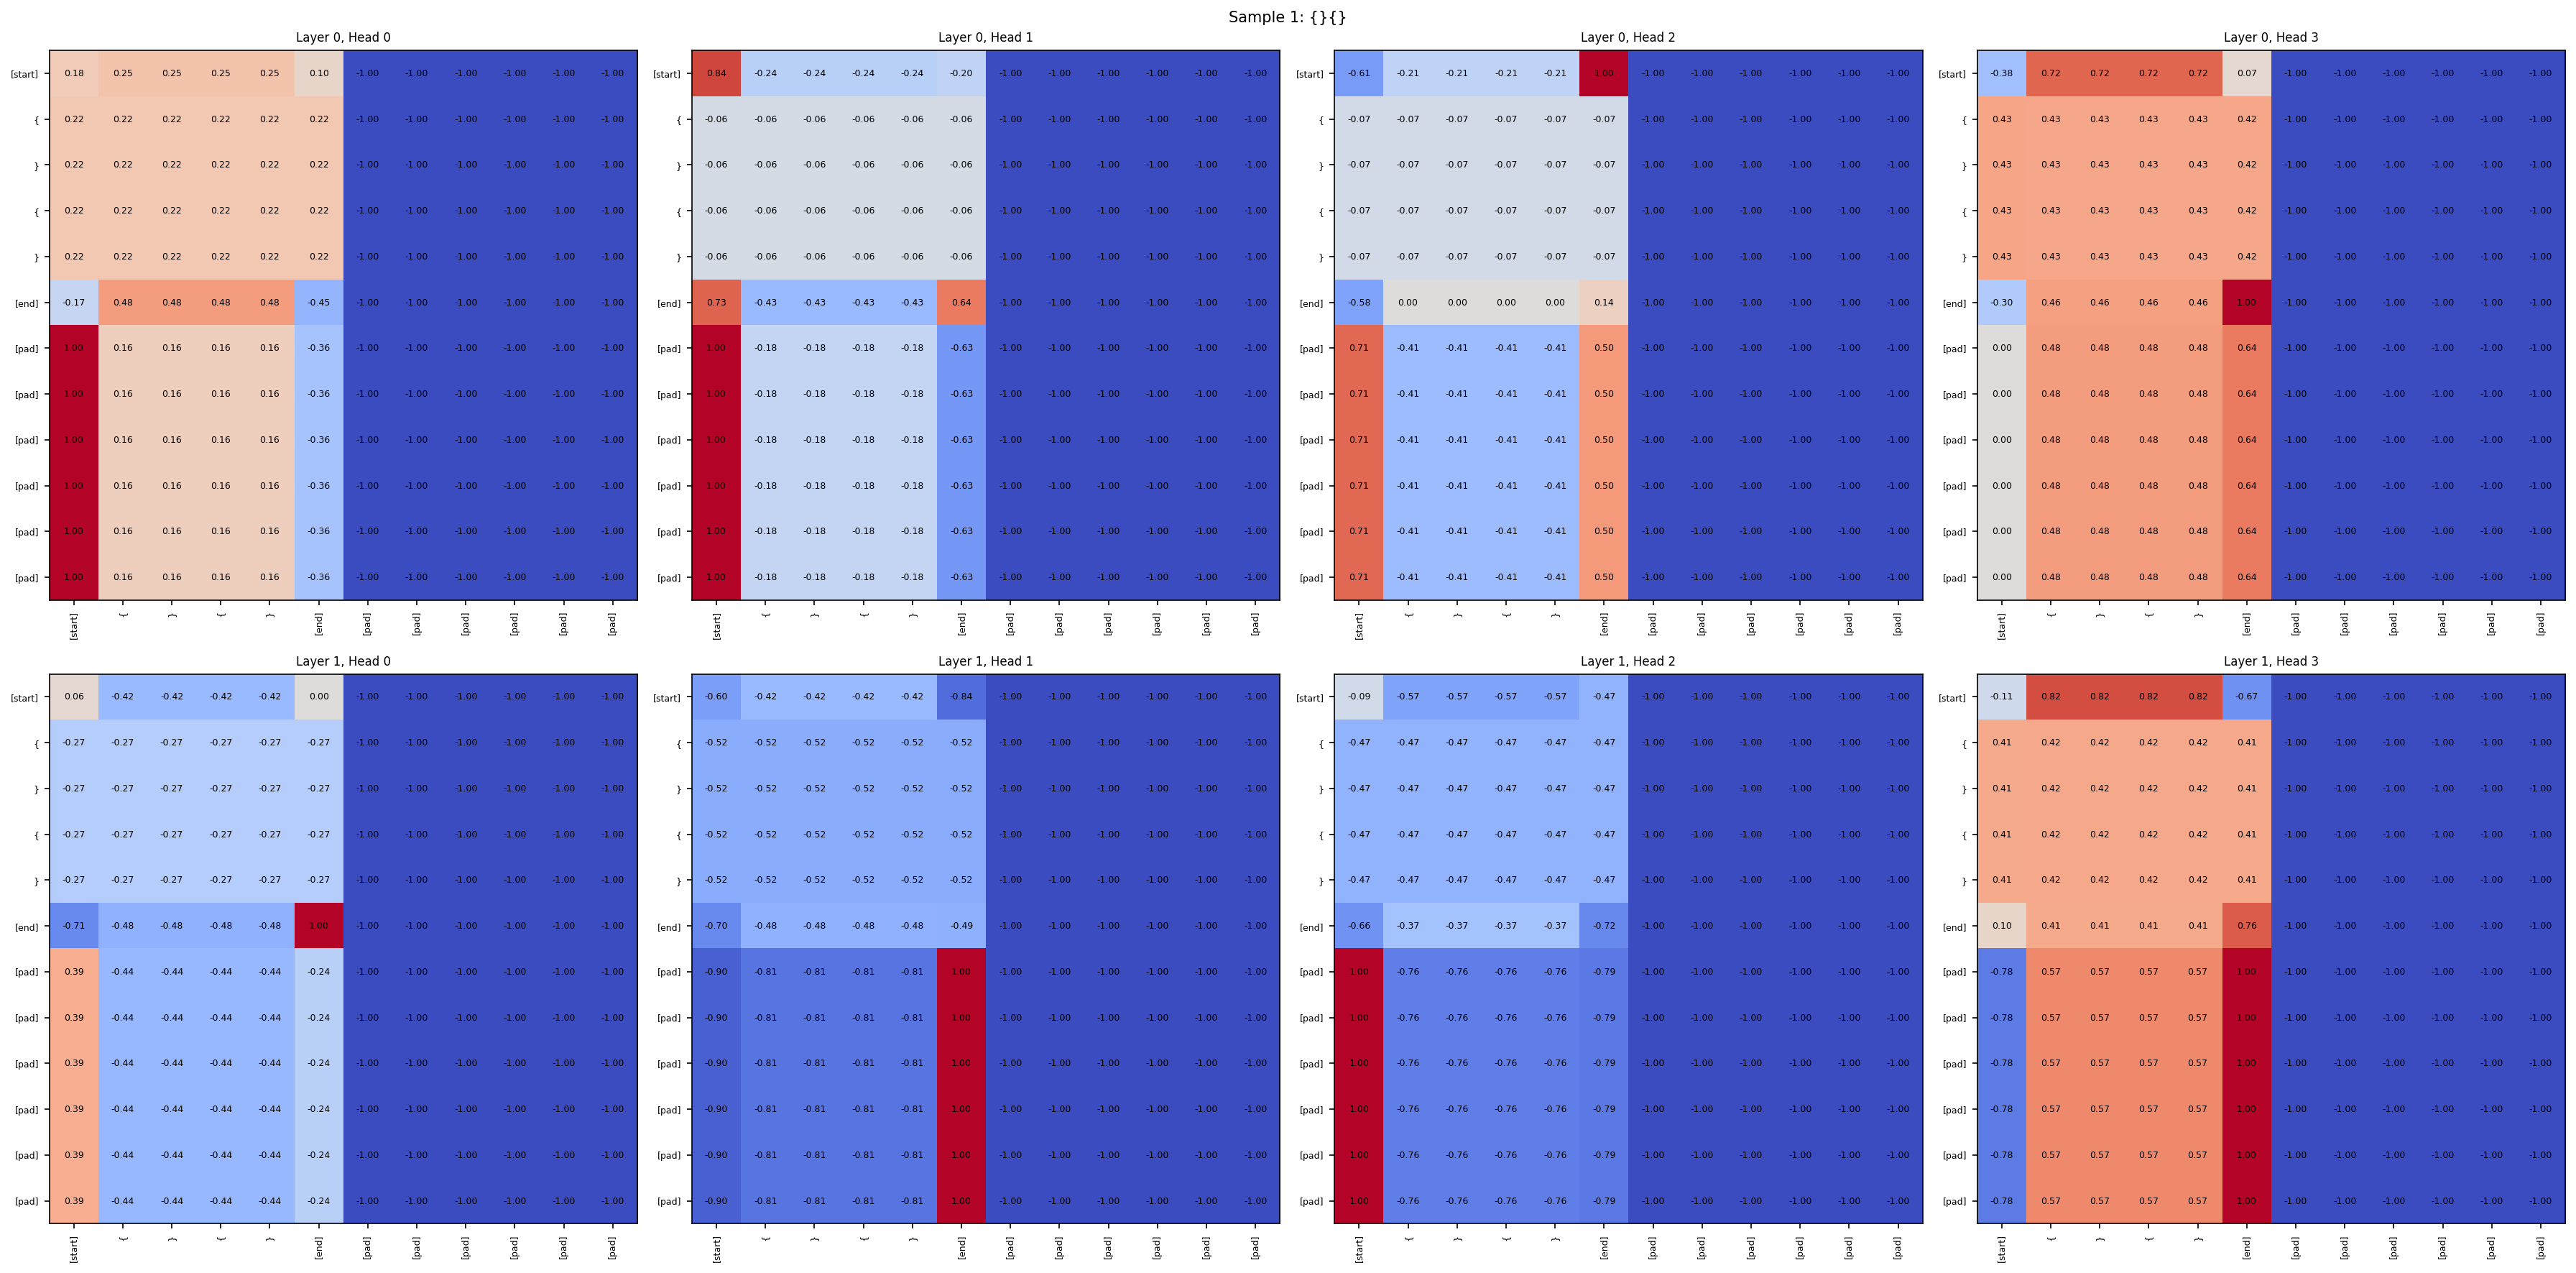

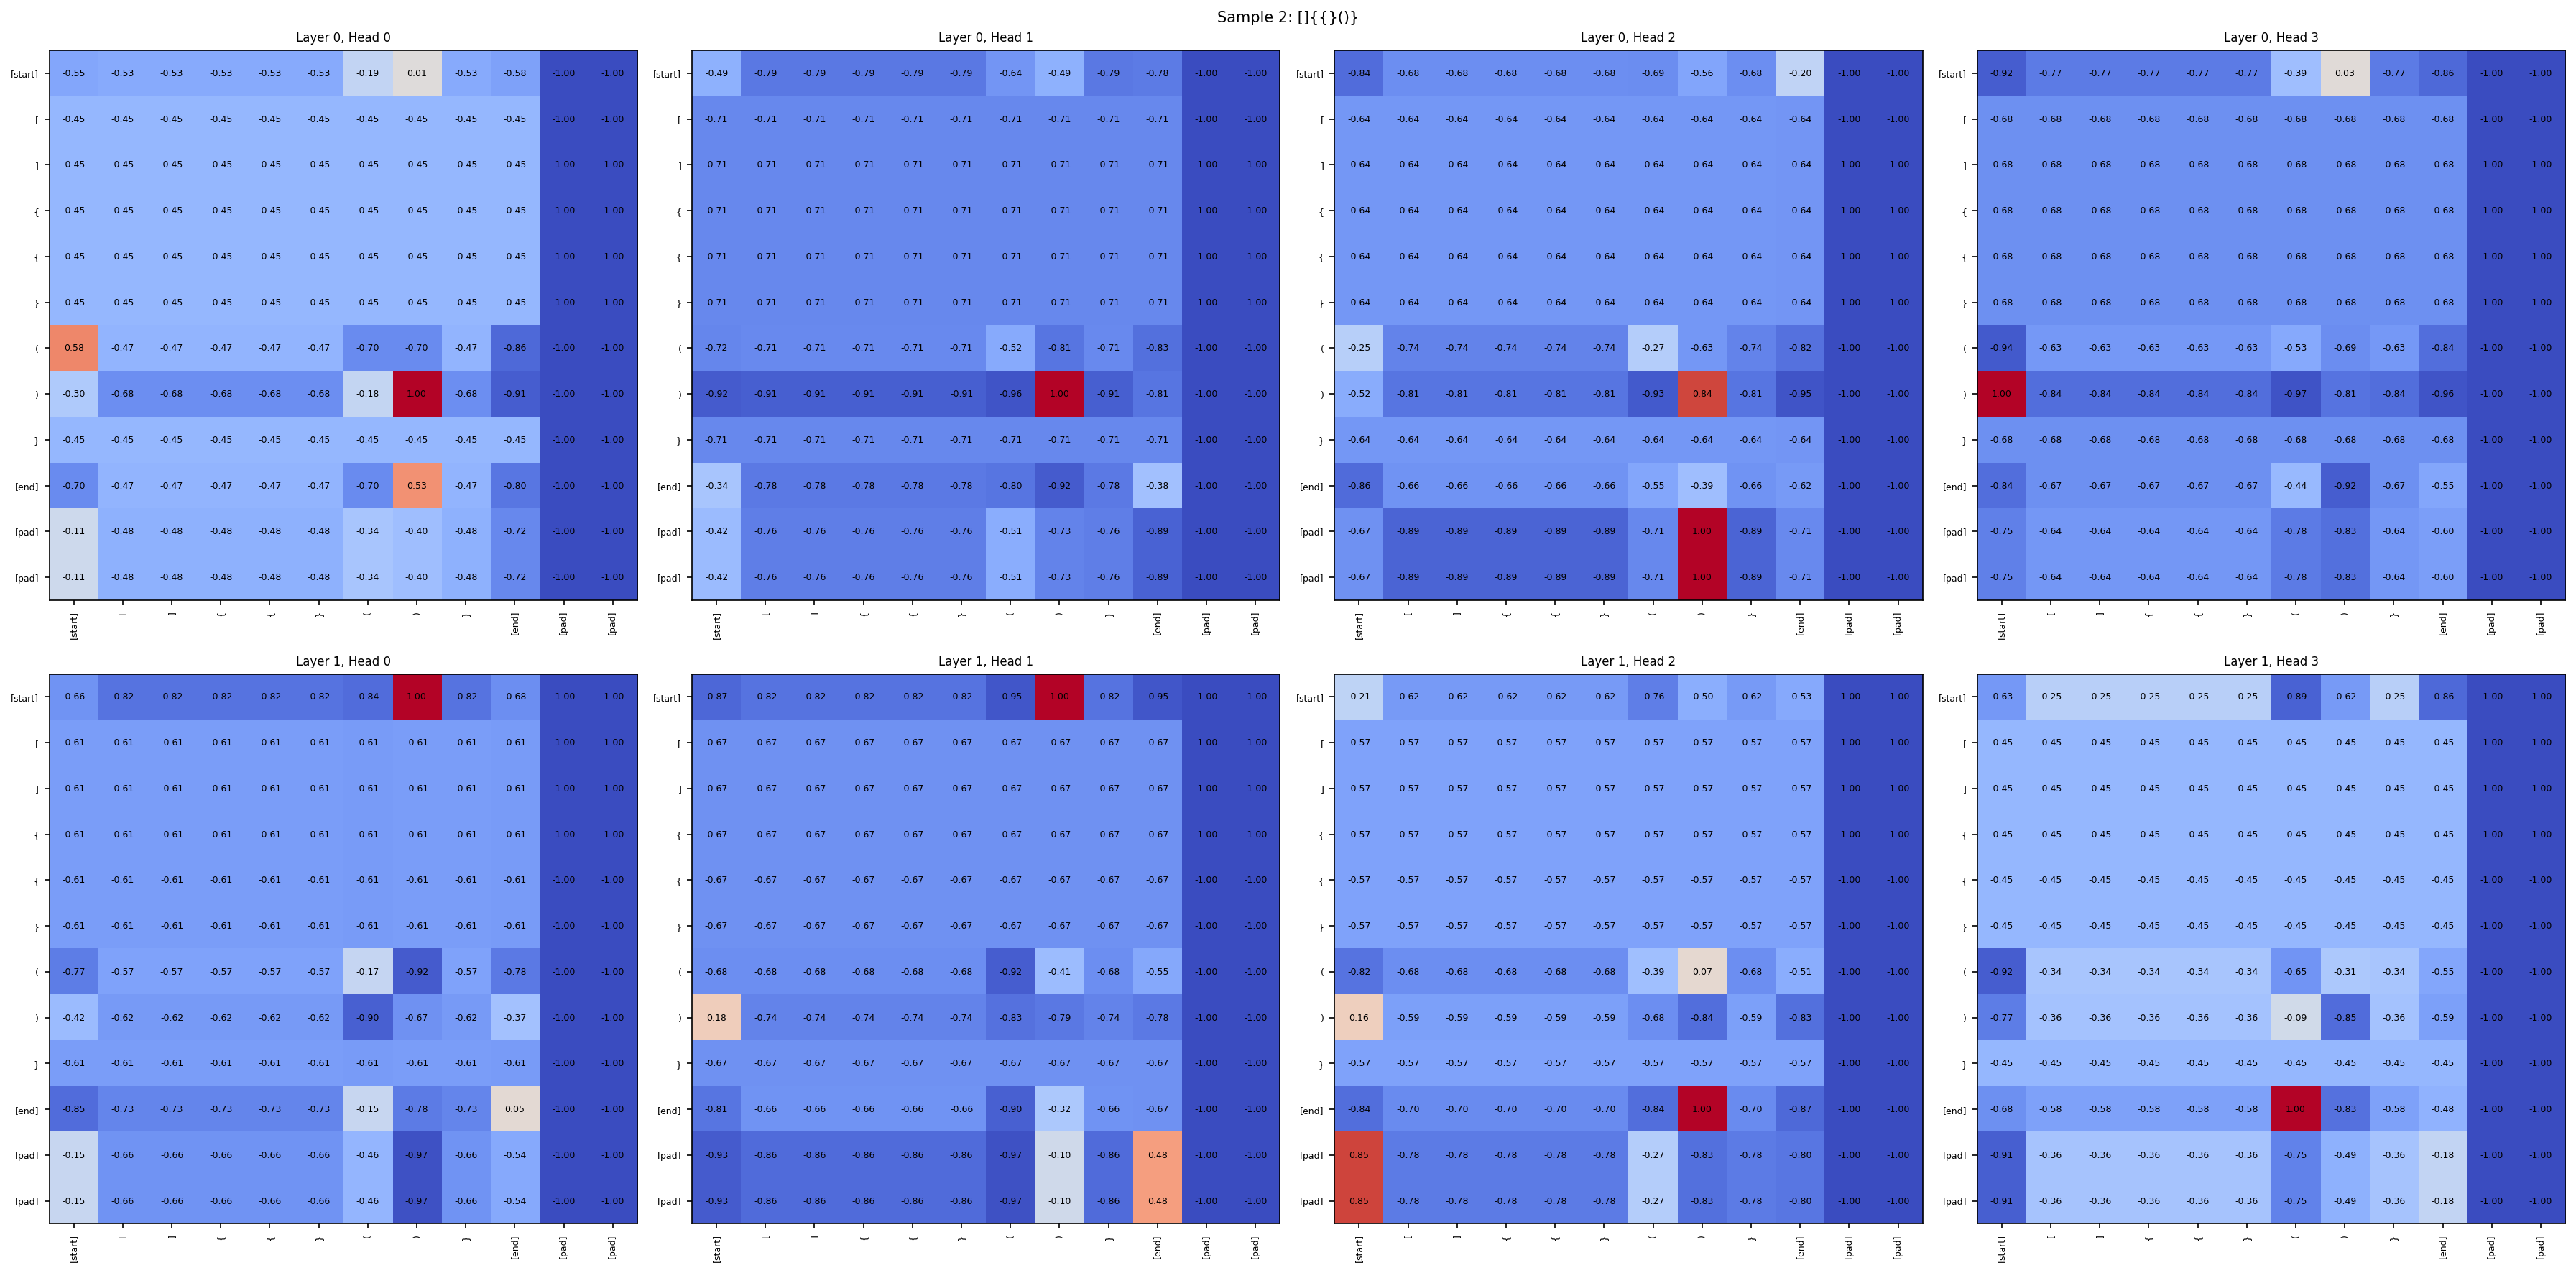

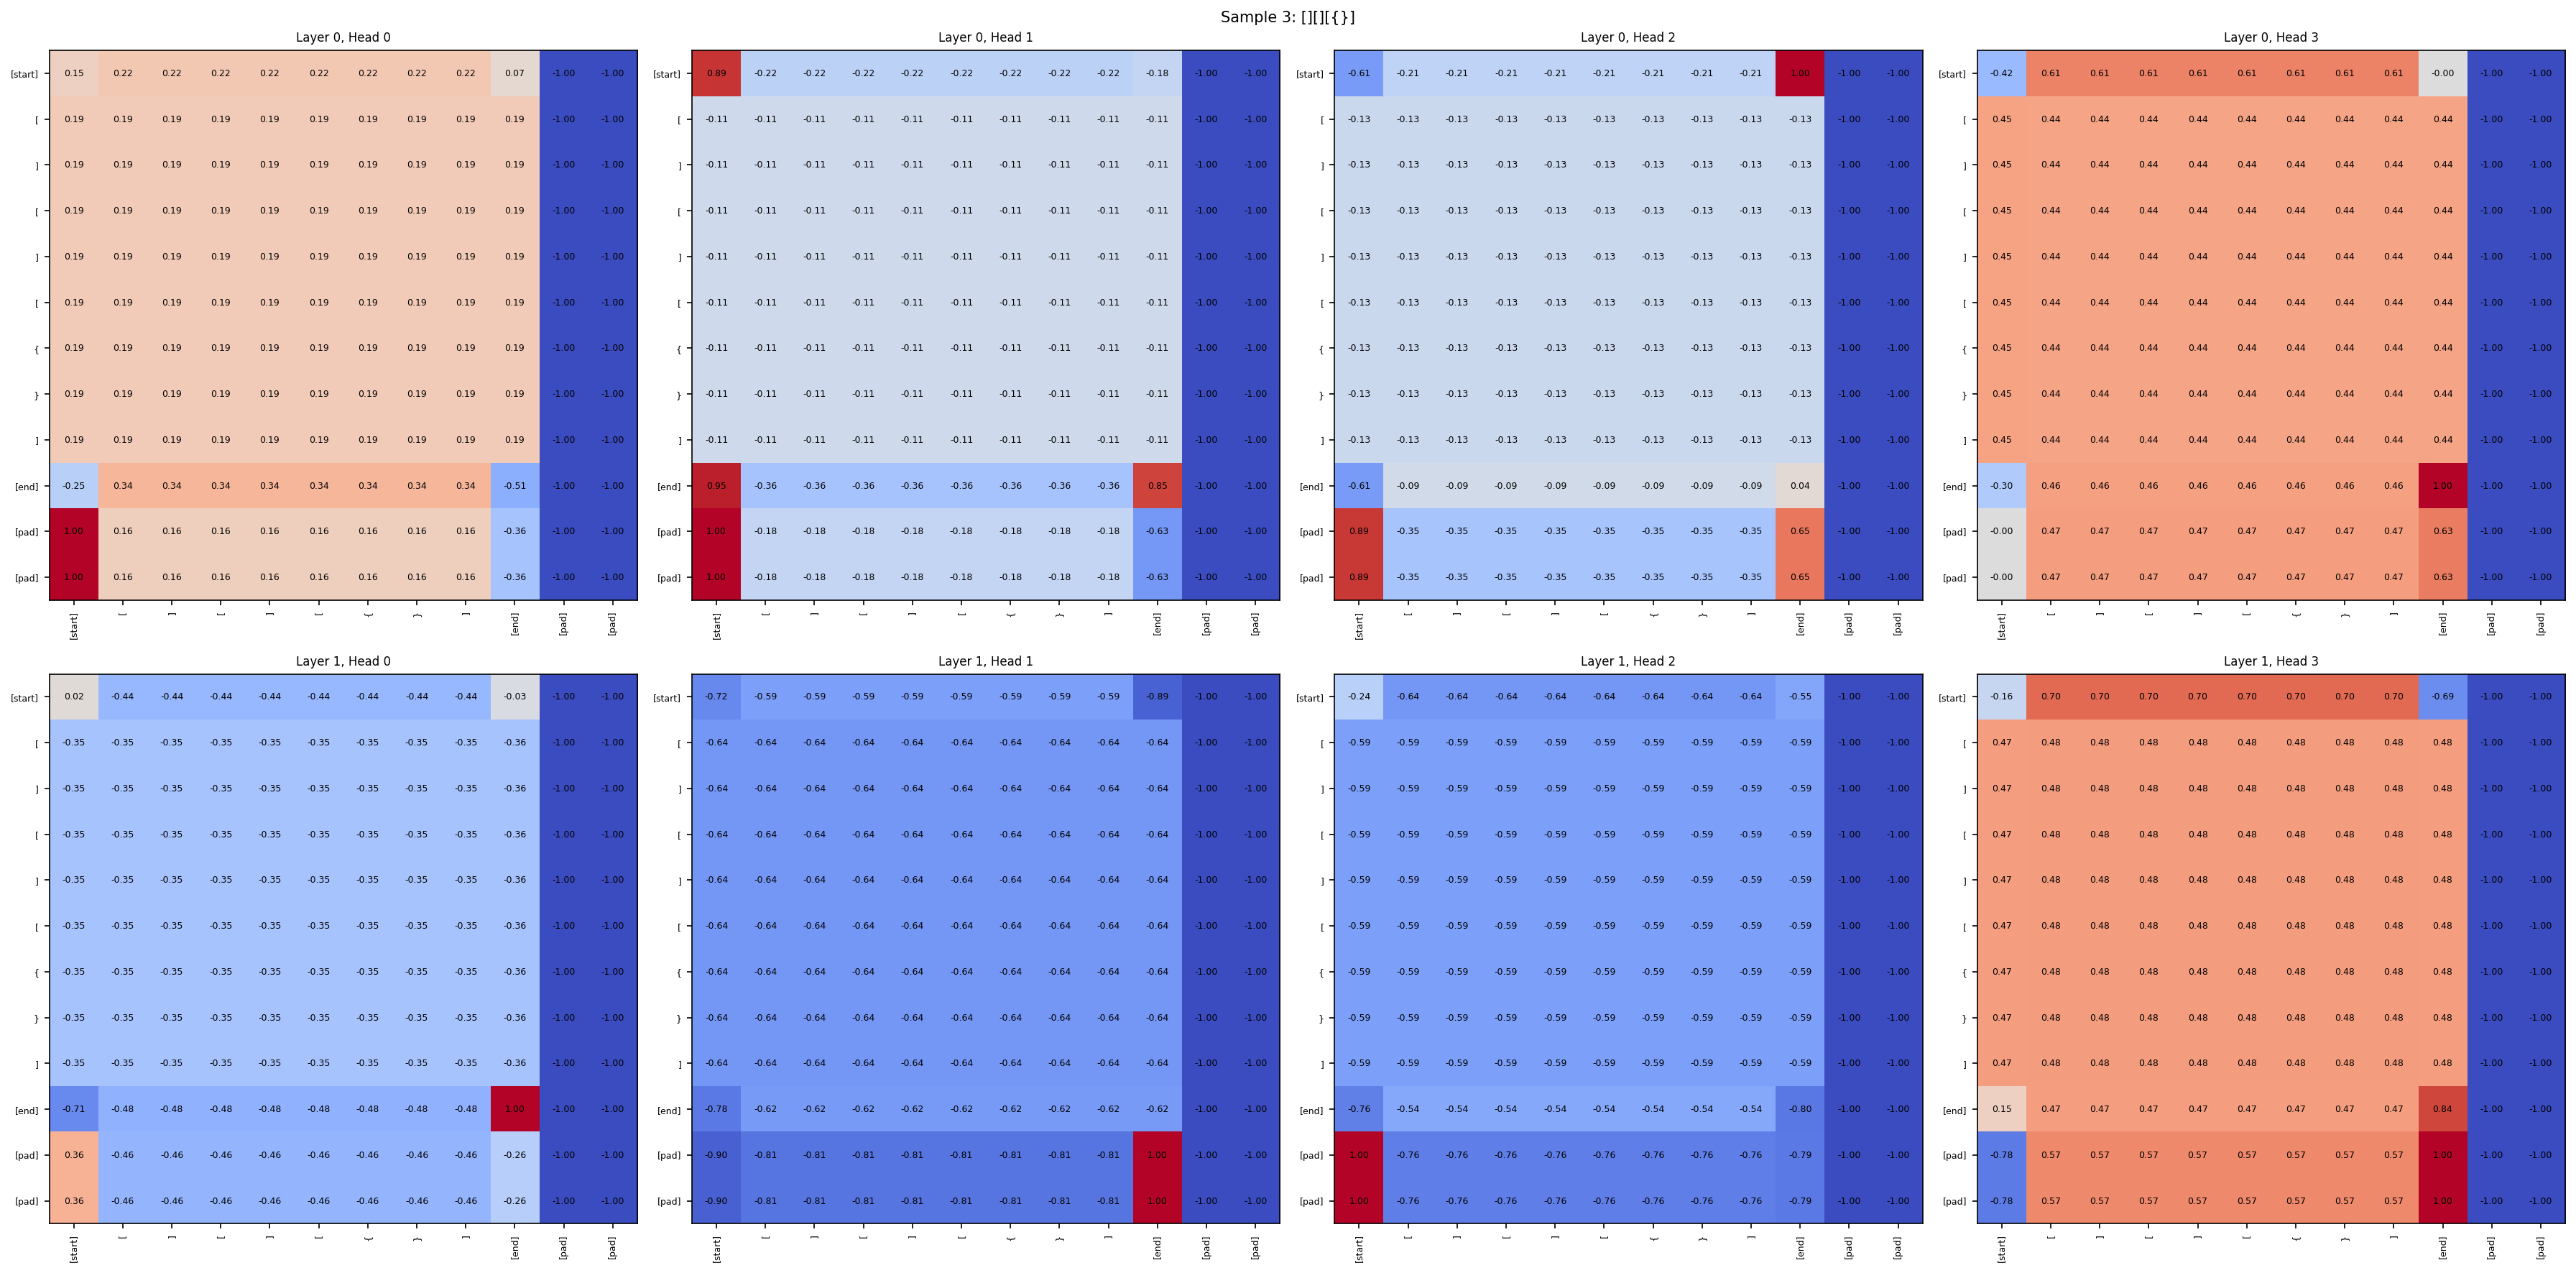

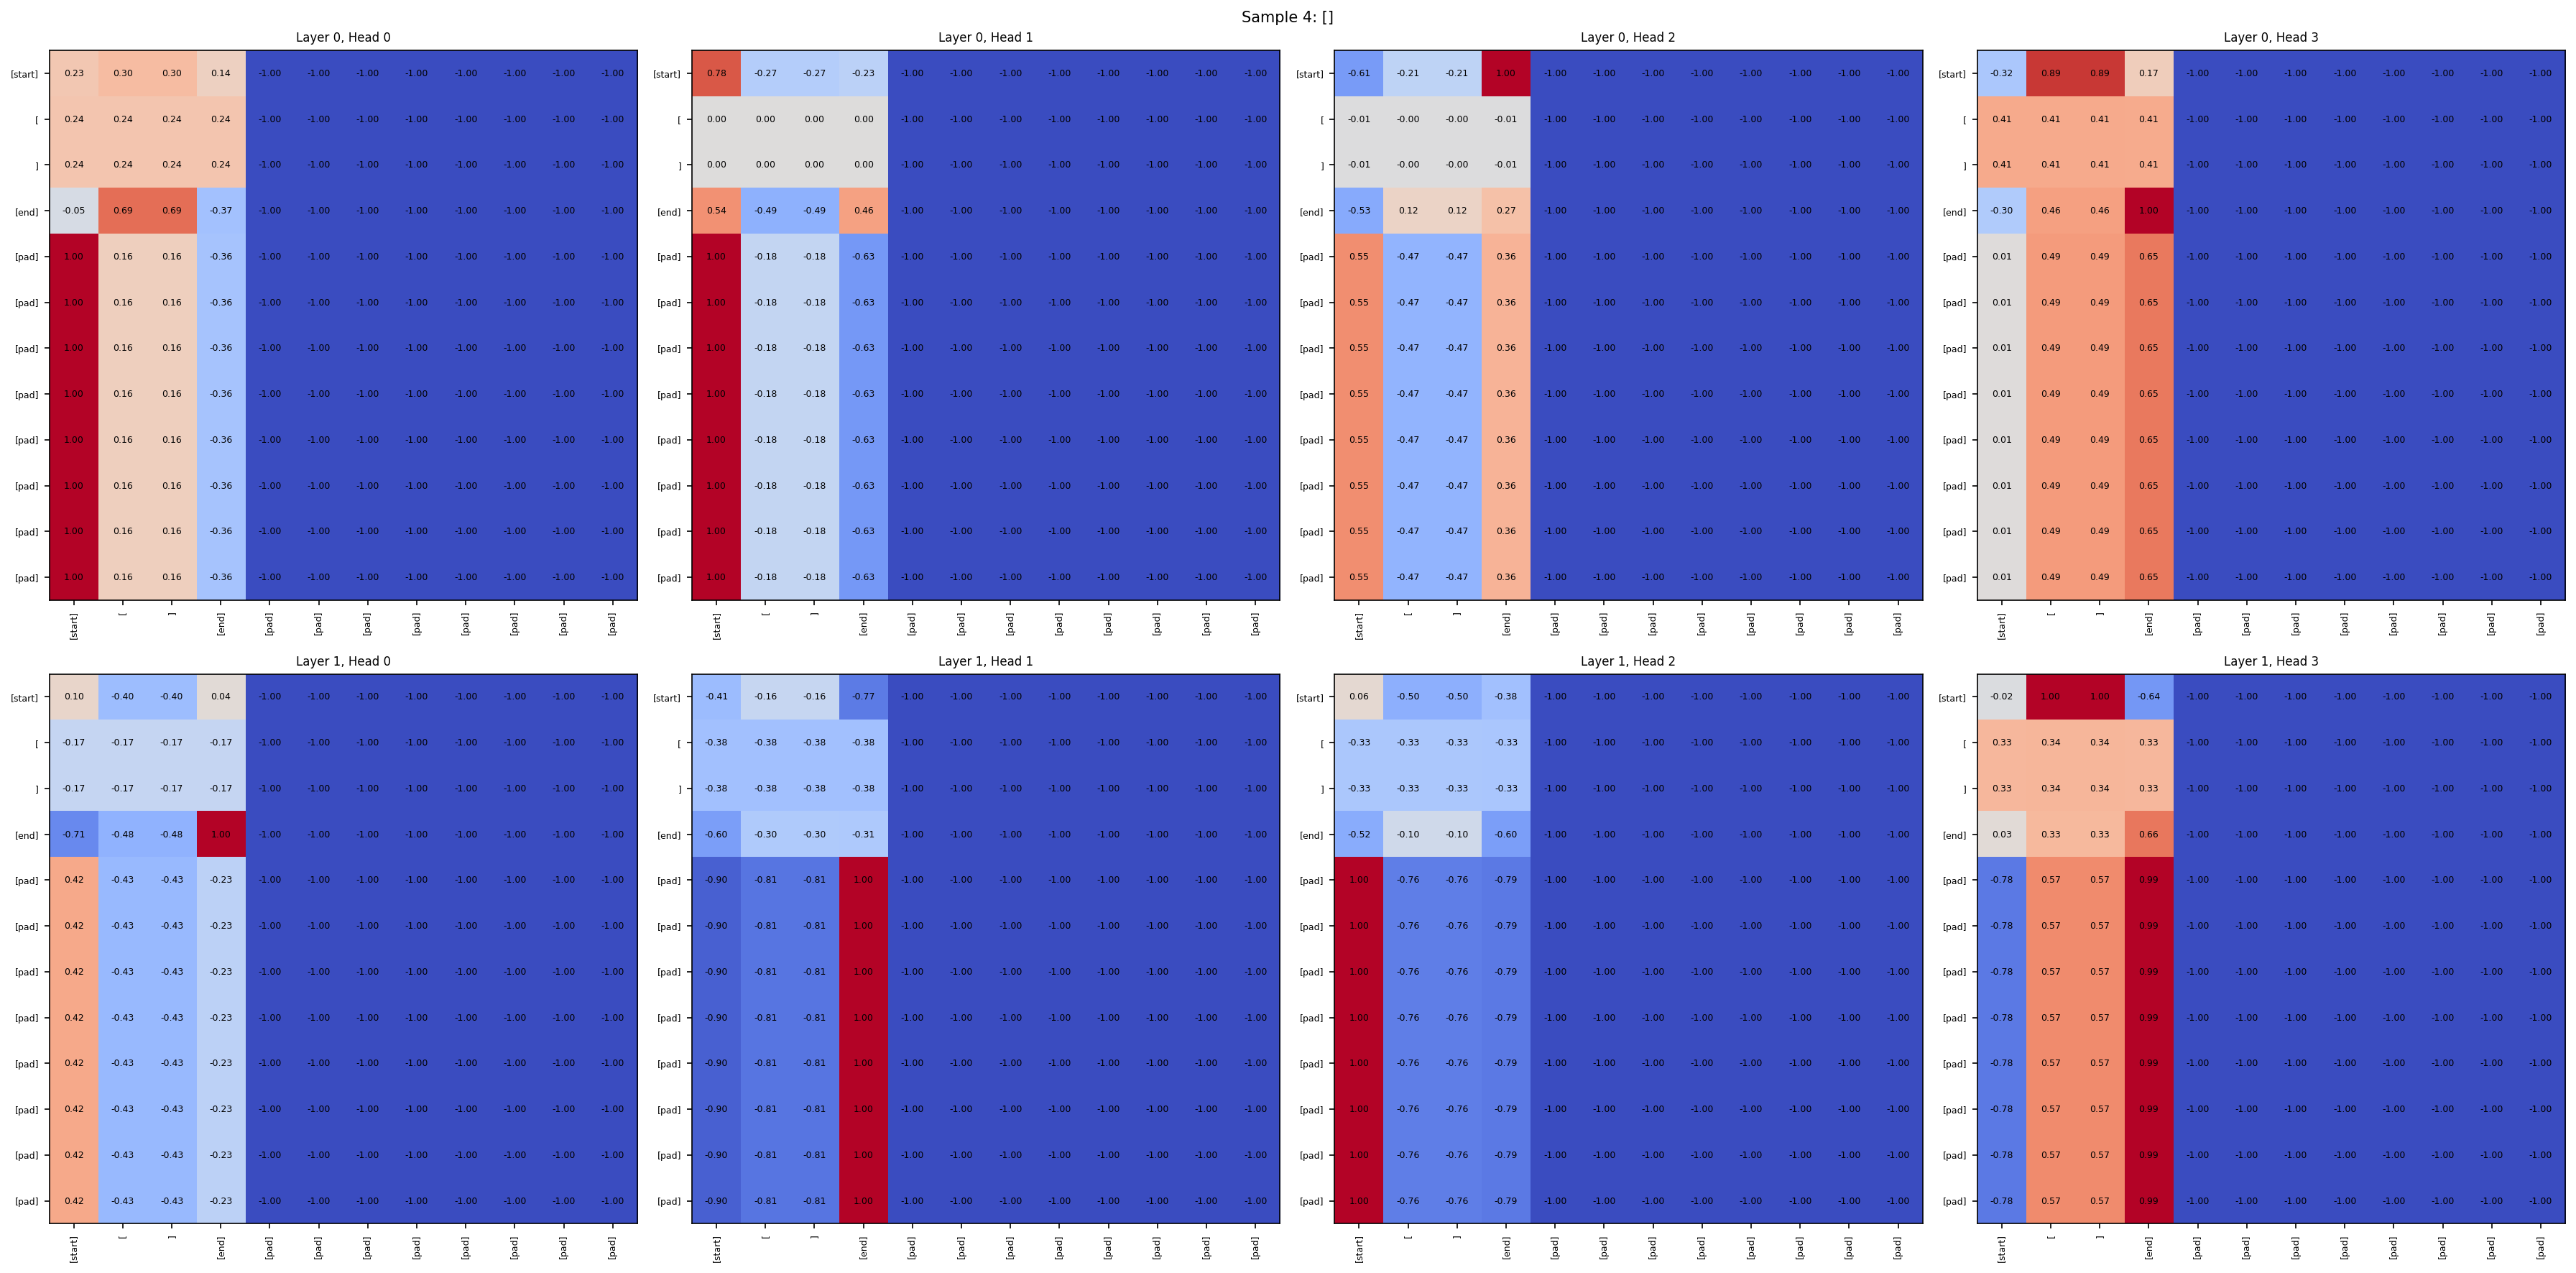

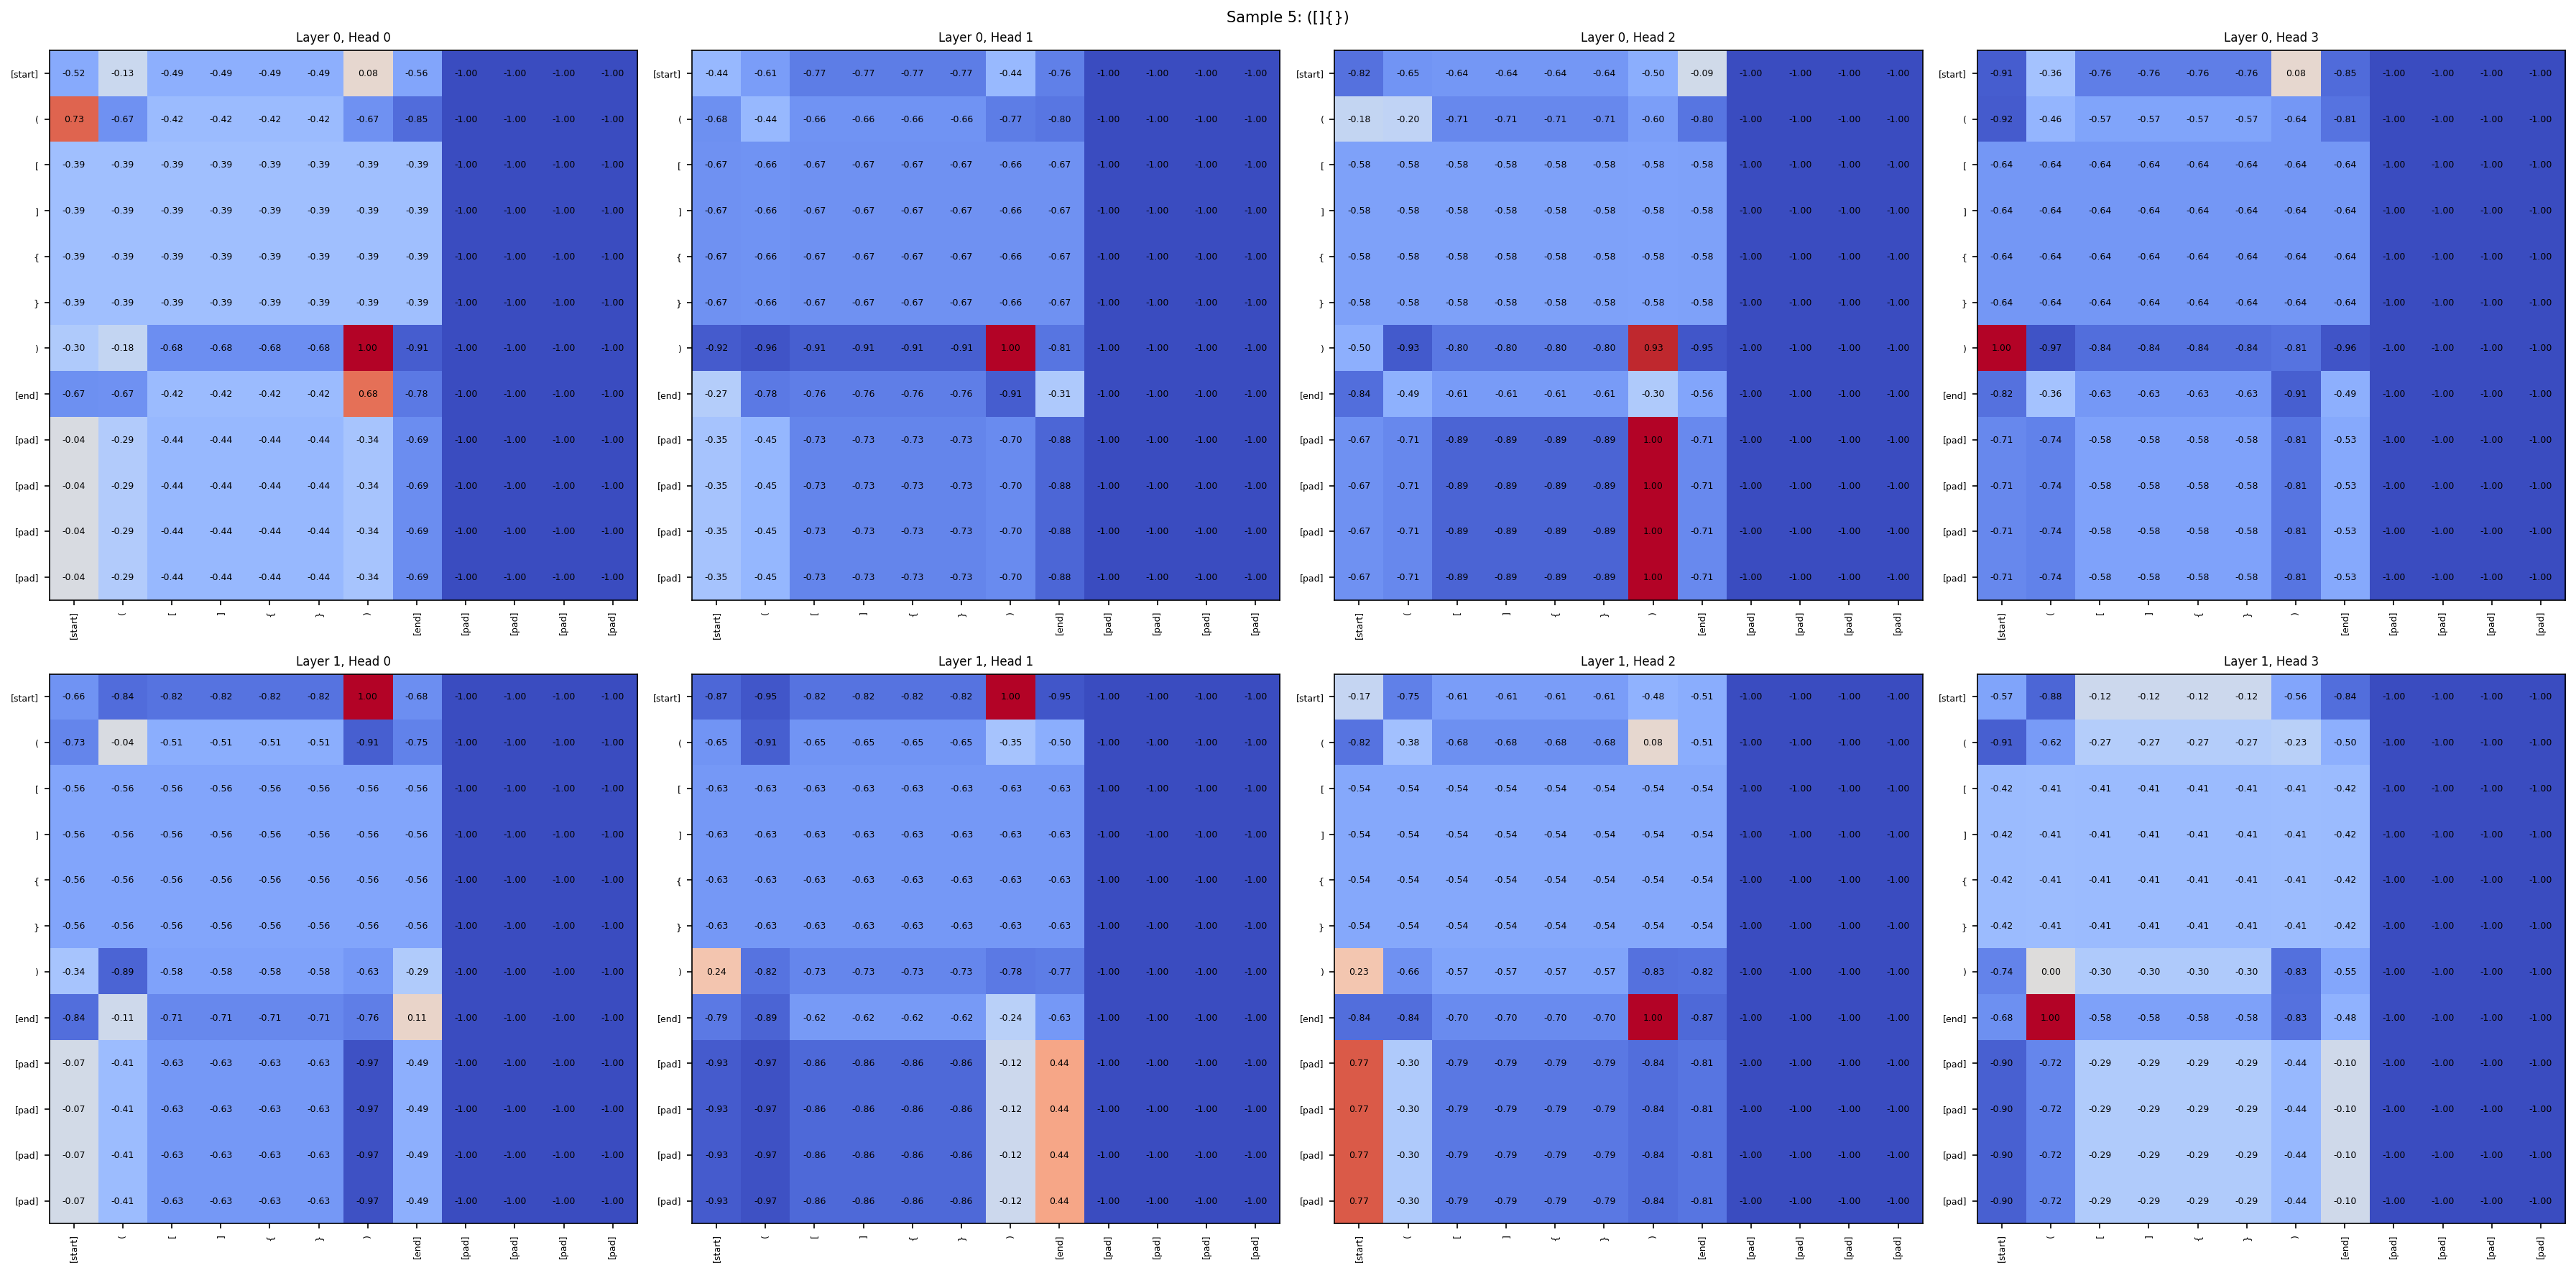

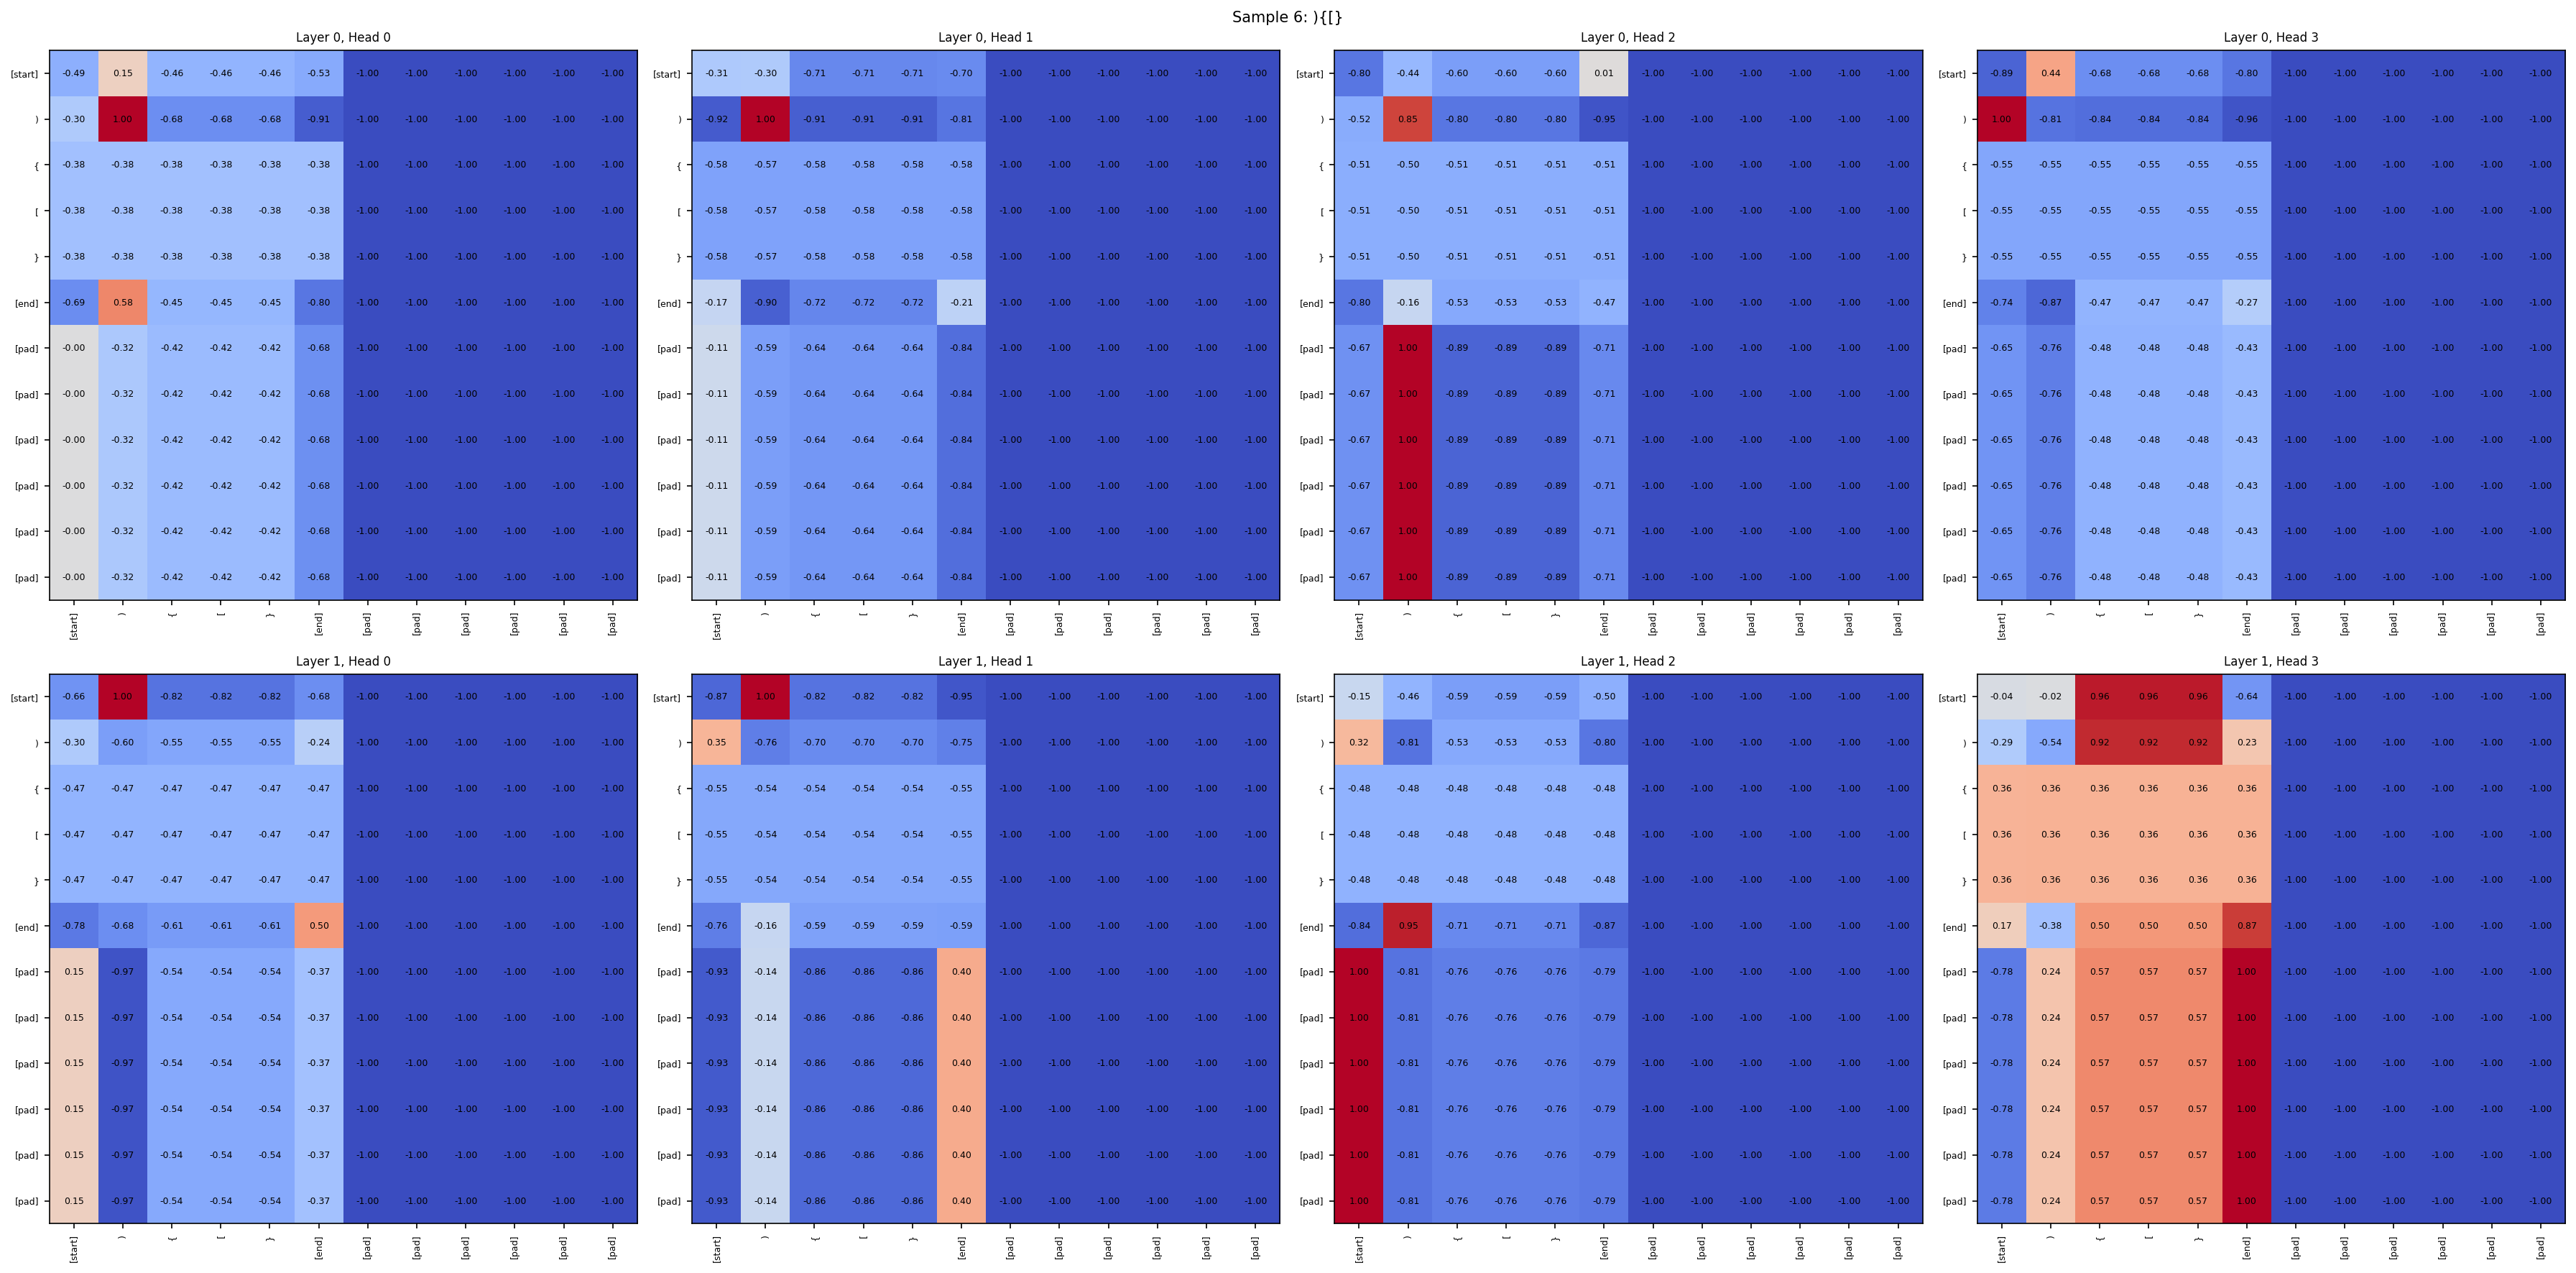

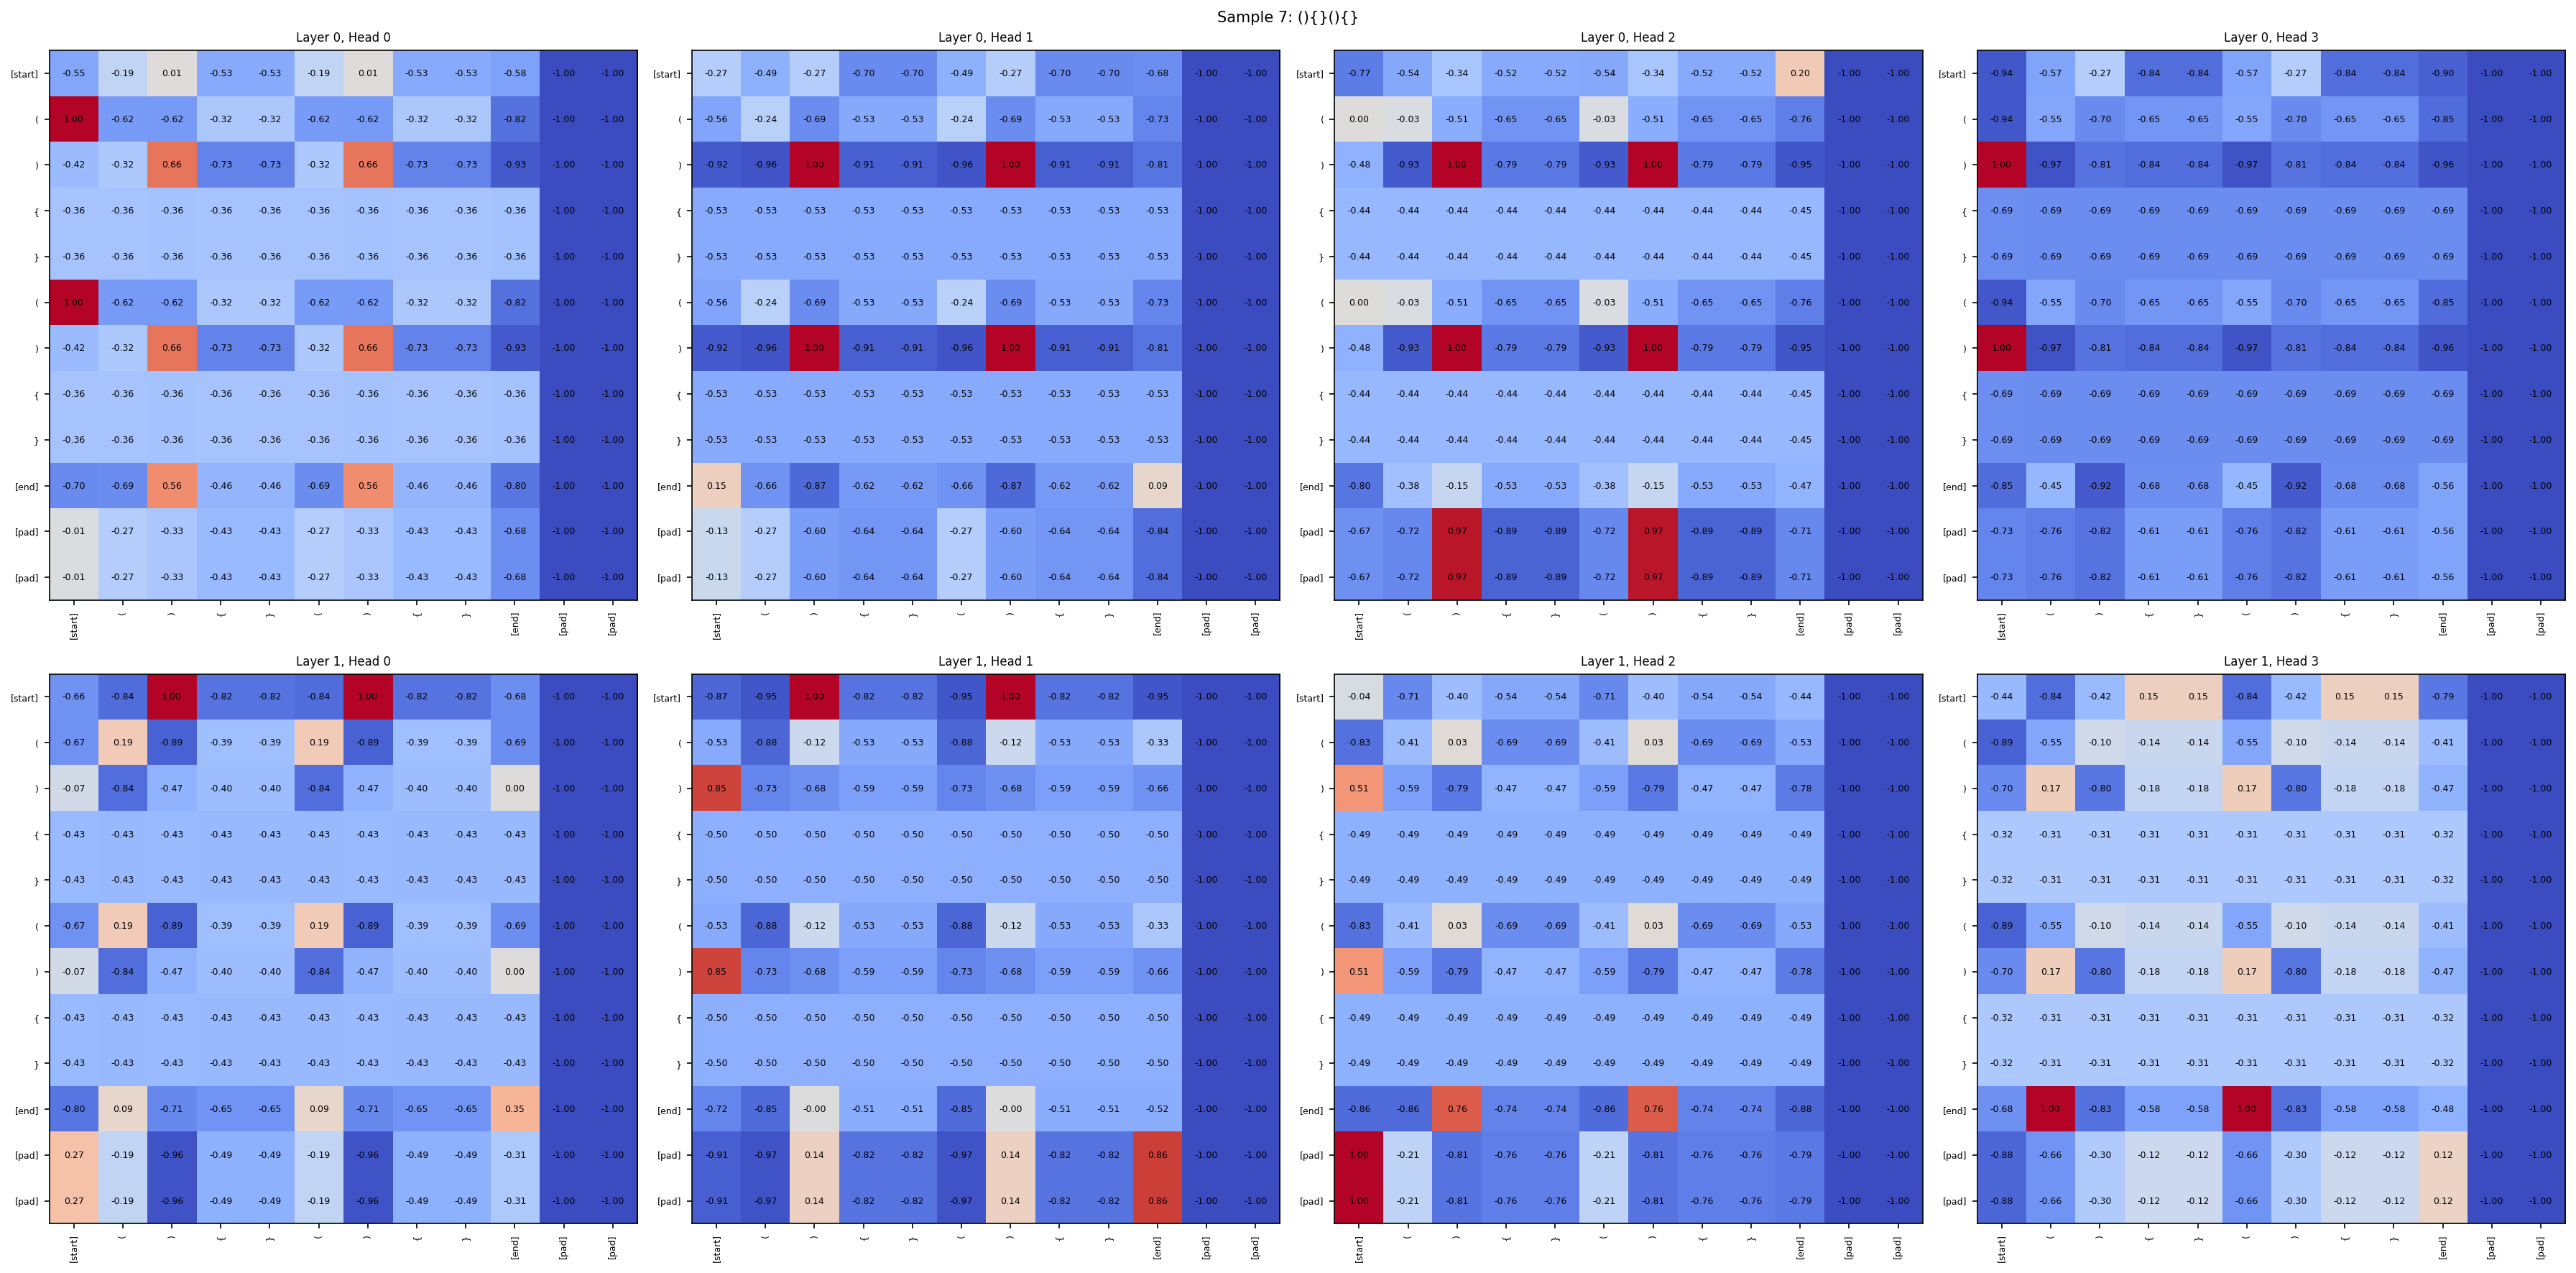

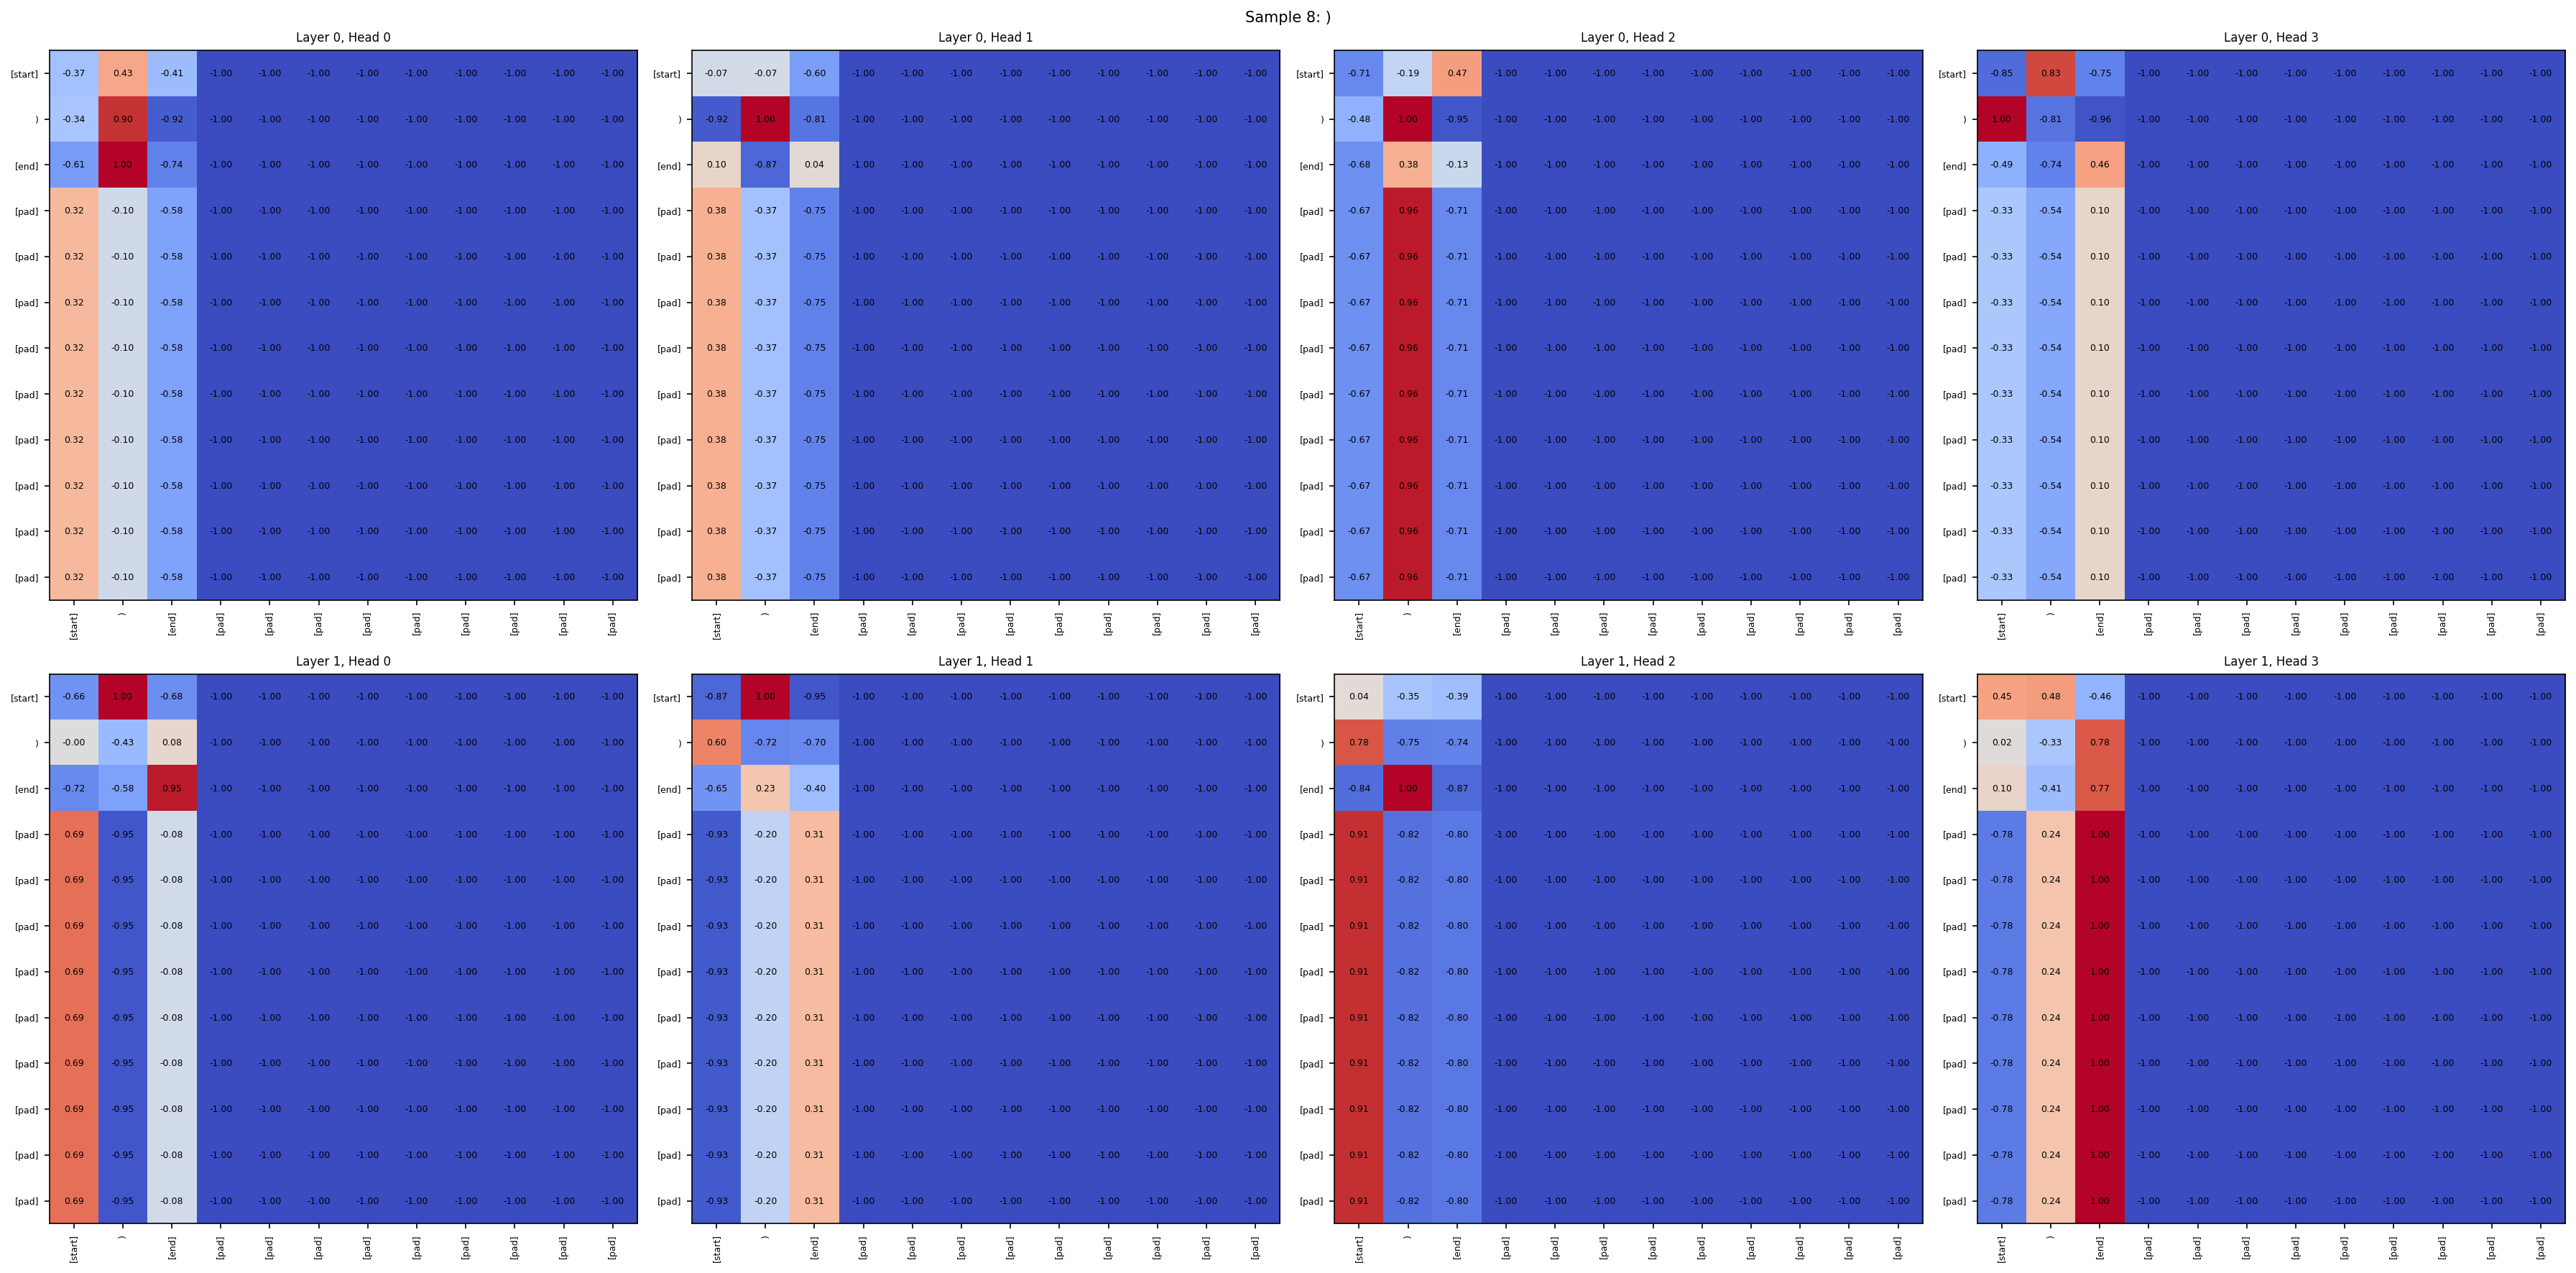

In [106]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

# Experiment 2

We will experiment with the same grammar, using a causal mask instead of a bidirectional one.


In [86]:
model_two = TransformerClassifier(model_config).to(device)

# Experiment 3

Dyck-3


In [87]:
k = 3

In [88]:
path = generate_dataset(
    n=5_000,
    k=3,
    min_length=0,
    max_length=10,
    balanced=0.5,
)

File data/dyck-3_5000-samples_10-len_p05.jsonl already exists.


In [89]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()[]{}'

In [109]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 5000 samples from data/dyck-3_5000-samples_10-len_p05.jsonl


Tokenizing strings: 100%|██████████| 5000/5000 [00:00<00:00, 938575.01it/s]


In [110]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_dyck_2, [train_size, val_size, test_size])

In [111]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [112]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [113]:
model = TransformerClassifier(model_config).to(device)

In [114]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [115]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 43.5188 | Train Acc: 55.20%
Val Loss: 6.6121 | Val Acc: 66.33%
Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 41.4798 | Train Acc: 62.50%
Val Loss: 6.3508 | Val Acc: 66.33%
Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 39.9179 | Train Acc: 63.50%
Val Loss: 6.0586 | Val Acc: 66.33%
Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 37.9790 | Train Acc: 65.25%
Val Loss: 5.8031 | Val Acc: 70.67%
Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 36.1297 | Train Acc: 68.75%
Val Loss: 5.3977 | Val Acc: 70.67%
Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 34.0473 | Train Acc: 70.08%
Val Loss: 5.0323 | Val Acc: 65.50%
Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 30.5234 | Train Acc: 74.62%
Val Loss: 4.2274 | Val Acc: 88.50%
Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 23.8396 | Train Acc: 83.38%
Val Loss: 3.1828 | Val Acc: 84.83%
Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 16.6344 | Train Acc: 89.12%
Val Loss: 1.9096 | Val Acc: 90.33%
Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 10.2019 | Train Acc: 95.97%
Val Loss: 1.1485 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 6.8847 | Train Acc: 99.58%
Val Loss: 0.7995 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 4.9586 | Train Acc: 100.00%
Val Loss: 0.5554 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.8001 | Train Acc: 100.00%
Val Loss: 0.4265 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.9860 | Train Acc: 100.00%
Val Loss: 0.3215 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.4185 | Train Acc: 100.00%
Val Loss: 0.2587 | Val Acc: 100.00%


In [116]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Test Loss: 1.2153 | Test Acc: 100.00%


train_acc,▁▁▂▃▃▂▃▃▃▃▃▄▄▃▄▄▄▄▄▅▆▆▆▆▇▇██████████████
train_loss,████▇██▇█▇▆▇▇▆▆▆▆▅▅▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▃▃▄▂▁▁▅▆▆▅▆▆██████████████████████
val_loss,██▇█▇█▇▇▆▆▆▆▅▅▄▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.03734
val_acc,100.0
val_loss,0.02674


In [117]:
batch = next(iter(test_dataloader))
batch

[('[][[][()]]', '){[}', '){[}', '(){([()])}', '){[}', '', ')', '[()]'),
 tensor([1., 0., 0., 1., 0., 1., 0., 1.], device='mps:0'),
 tensor([[0., 5., 6., 5., 5., 6., 5., 3., 4., 6., 6., 2.],
         [0., 4., 7., 5., 8., 2., 1., 1., 1., 1., 1., 1.],
         [0., 4., 7., 5., 8., 2., 1., 1., 1., 1., 1., 1.],
         [0., 3., 4., 7., 3., 5., 3., 4., 6., 4., 8., 2.],
         [0., 4., 7., 5., 8., 2., 1., 1., 1., 1., 1., 1.],
         [0., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 5., 3., 4., 6., 2., 1., 1., 1., 1., 1., 1.]], device='mps:0')]

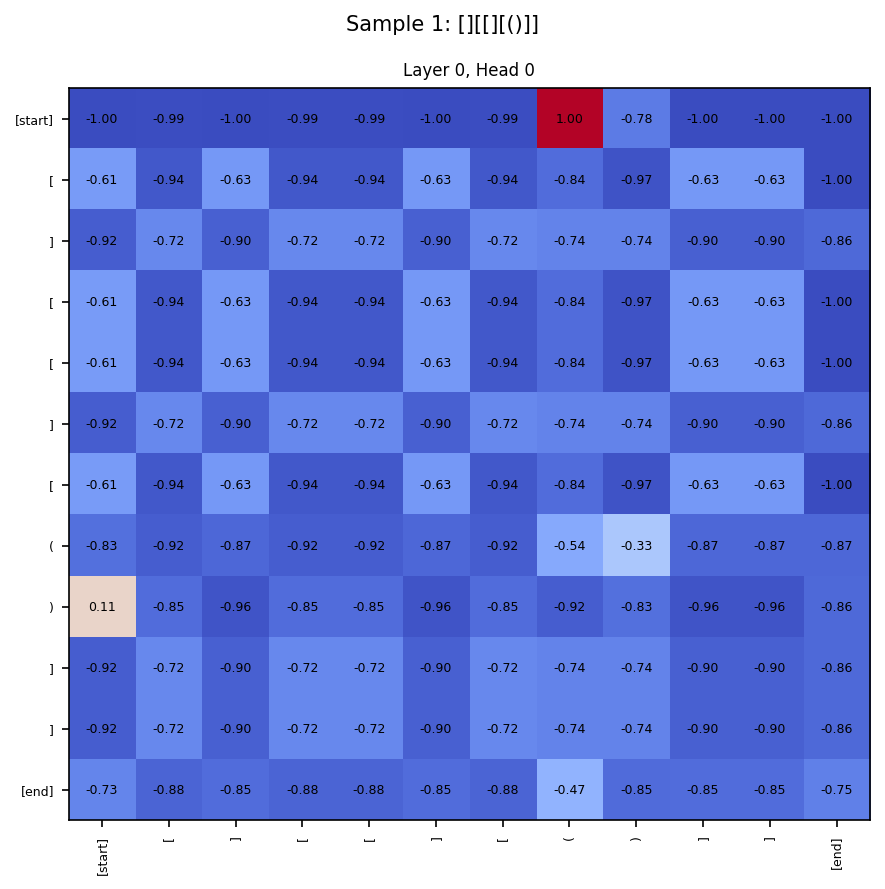

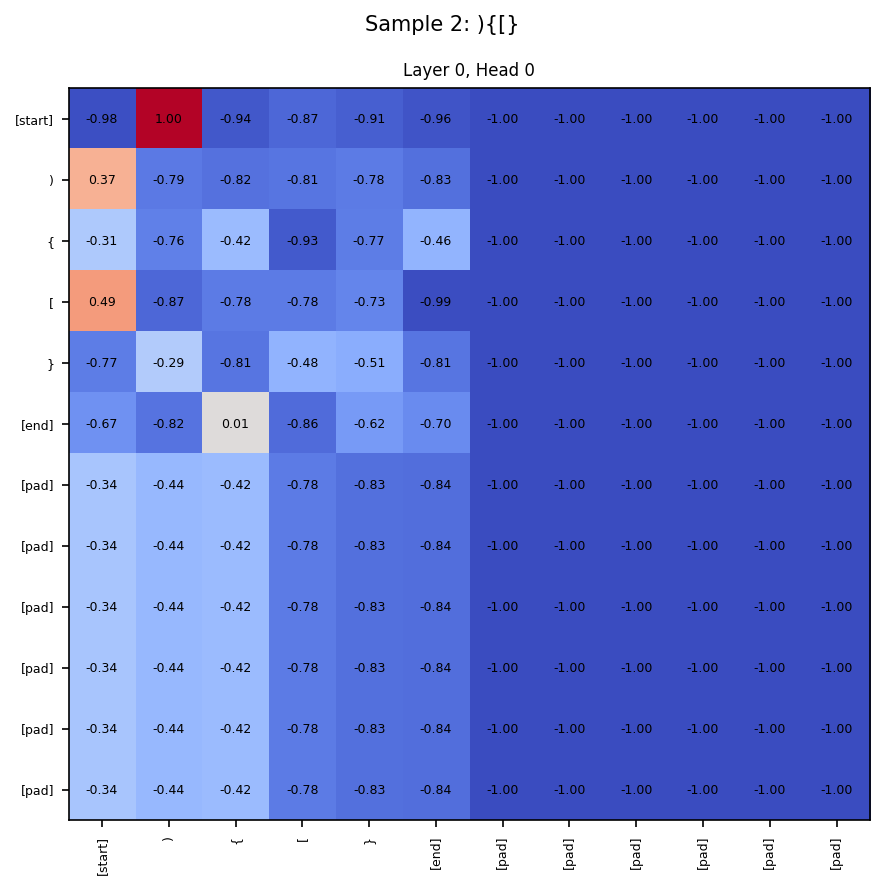

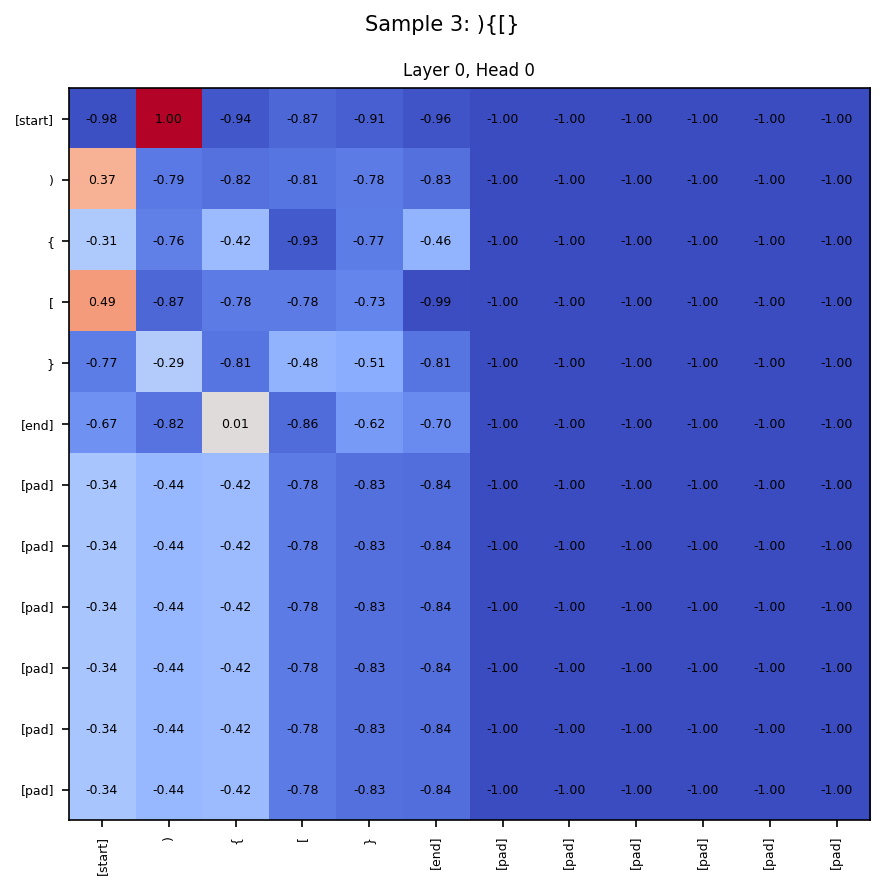

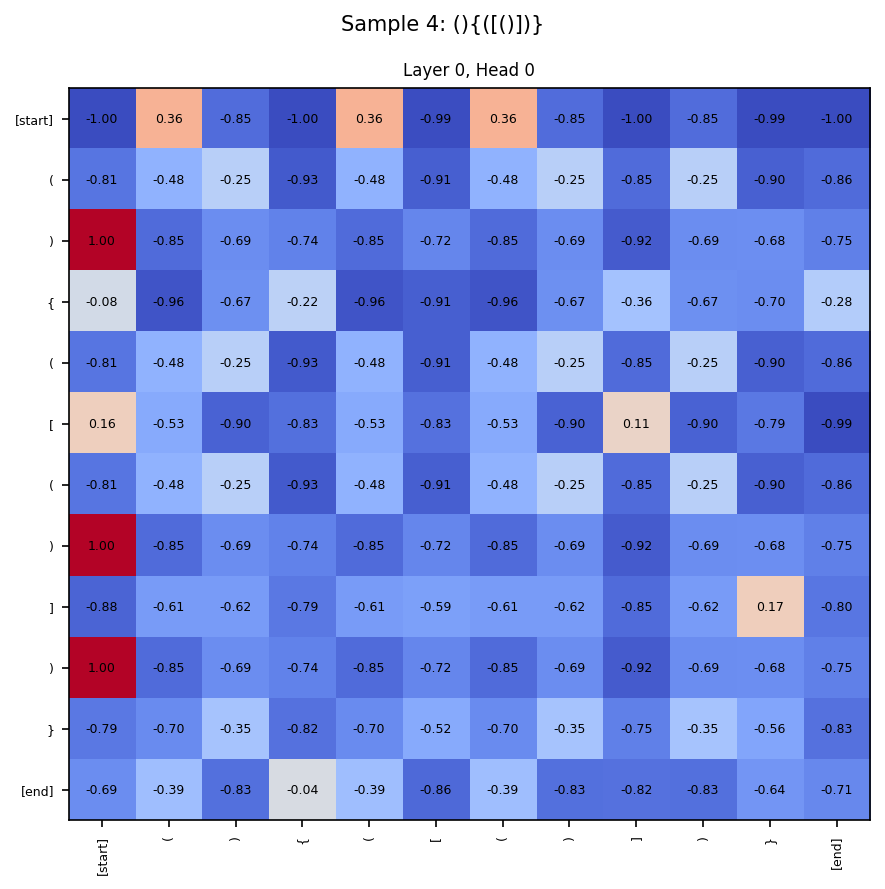

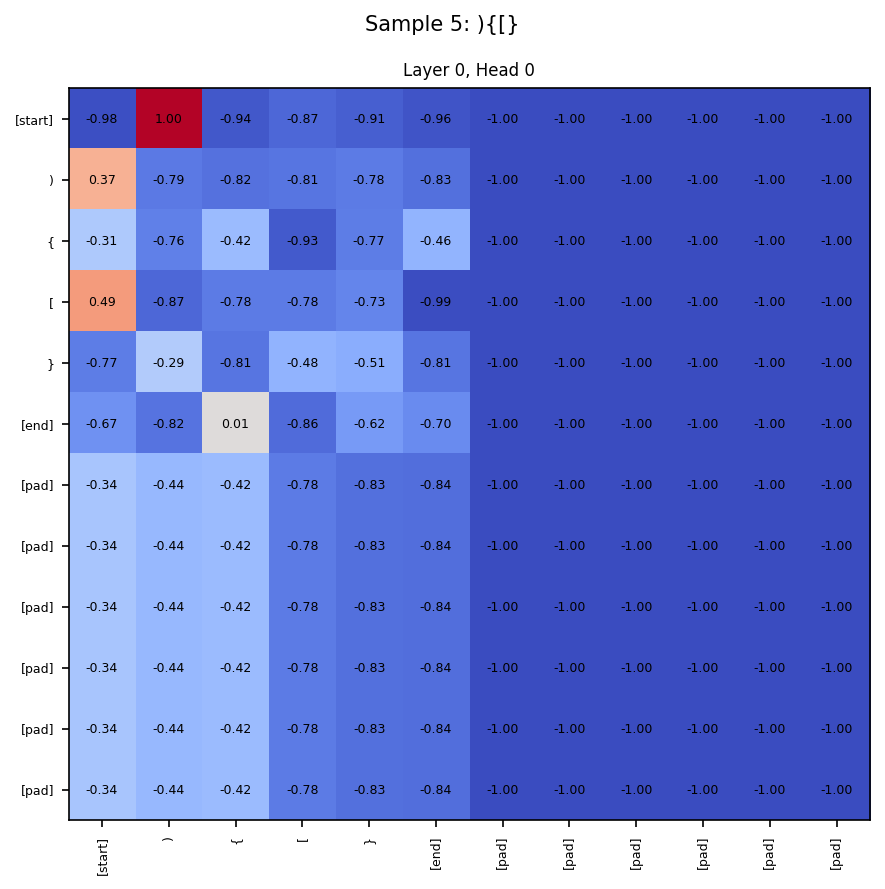

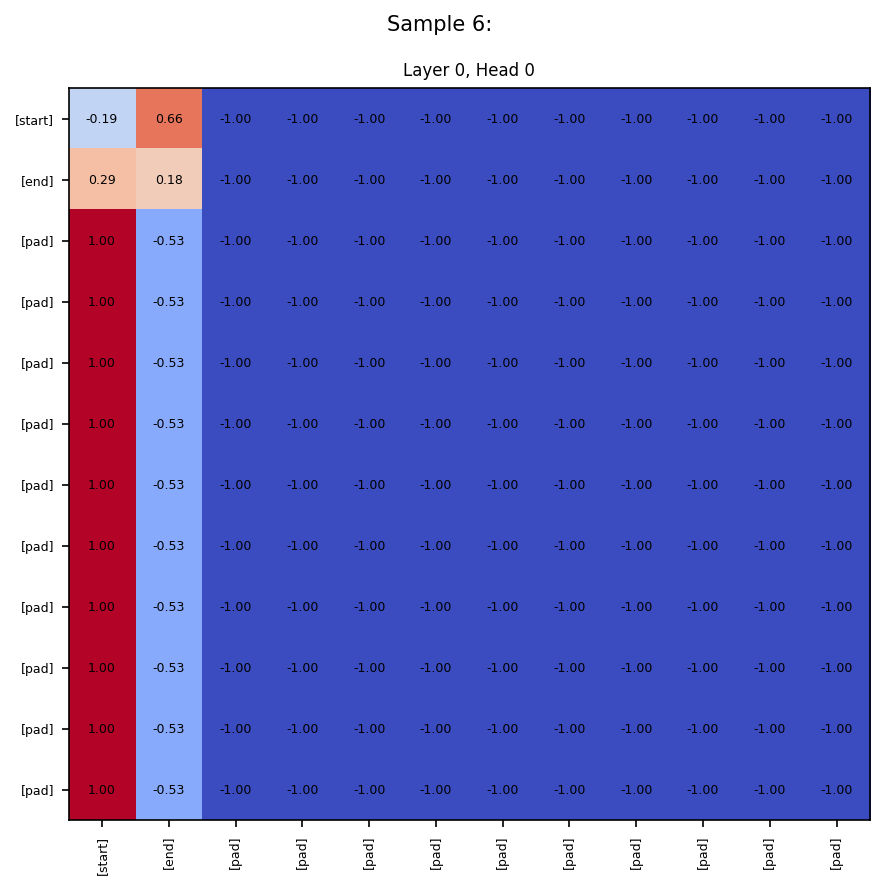

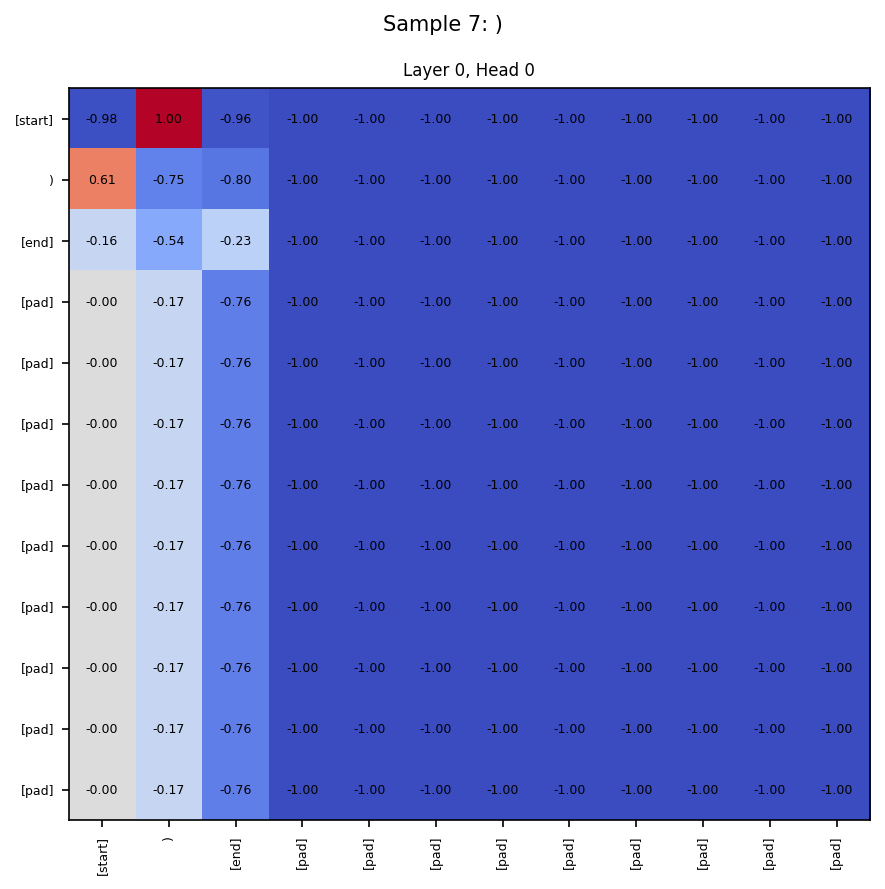

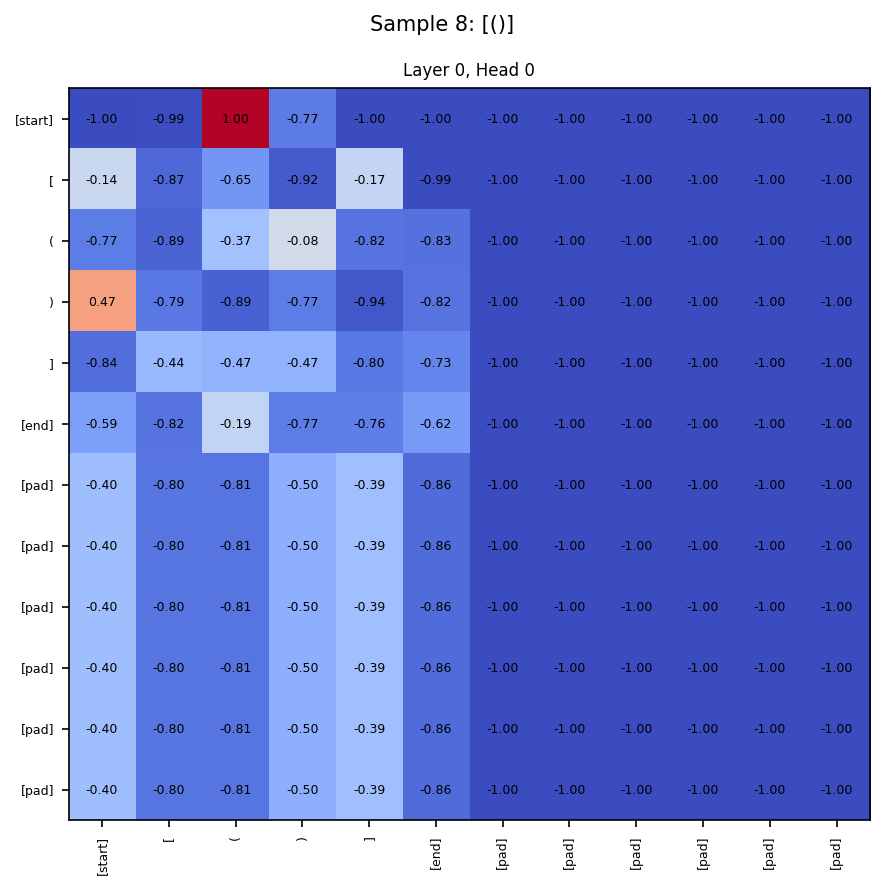

In [118]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)